In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 100:00:00 -p gpu_quad --gres=gpu:teslaV100s:1 ./ctct_dense16.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-compass/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label,plot_performance, score2
from compass.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd


pretrainer = loadcompass('../../checkpoint/latest/pretrainer.pt')
data_path = '../../00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))
df_tpm.shape, df_label.shape

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)

df_task = onehot(df_label.response_label)

In [2]:
seeds = [24, 42, 64]

params = {'mode': 'LFT',
        'seed':42,
        'lr': 1e-5,
        'device':'cuda',
        'weight_decay': 1e-6,
        'batch_size':32, 
        'max_epochs':0,
        'task_loss_weight':1,
        'load_decoder':True,
        'task_loss_type': 'ce_loss', 
        'task_type': 'c',
        'task_dense_layer': [16],
        'task_batch_norms':True,
        'entropy_weight': 0.0,
        'with_wandb': False,
        'save_best_model':False,
        'verbose': False}

In [3]:
test_cohort_name = 'SU2CLC1(Pembro)'
train_cohort_name = '~SU2CLC1(Pembro)'

df_test_pannel = pd.read_csv('./test_pannel_SU2CLC1(Pembro).csv', index_col=0)
df_train_pannel = pd.read_csv('./train_pannel_~SU2CLC1(Pembro).csv', index_col=0)

## Get data for this cohort
cohort_idx = df_train_pannel.index
cohort_X = dfcx.loc[cohort_idx]
cohort_y = df_task.loc[cohort_idx]

train_X = cohort_X
train_y = cohort_y

test_cohort_idx = df_test_pannel.index
test_cohort_X = dfcx.loc[test_cohort_idx]
test_cohort_y = df_task.loc[test_cohort_idx]


print(len(cohort_idx), len(test_cohort_idx))

69 33


In [4]:
N = len(cohort_X)
N

69

In [5]:
new_cohort = 'SU2CLC1'
mode1_df_train_pannel = df_label[df_label.cohort != new_cohort]
N1 = len(mode1_df_train_pannel)
N1

1031

Evaludation on Model LFT


0it [00:00, ?it/s]


Saving the model to ./PT(10K)-PFT(1031)-LFT(69)-ep0/24/finetuner.pt


100%|##########| 3/3 [00:02<00:00,  1.24it/s]


Evaludation on Model LFT


0it [00:00, ?it/s]


Saving the model to ./PT(10K)-PFT(1031)-LFT(69)-ep0/42/finetuner.pt


100%|##########| 3/3 [00:00<00:00,  8.73it/s]


Evaludation on Model LFT


0it [00:00, ?it/s]


Saving the model to ./PT(10K)-PFT(1031)-LFT(69)-ep0/64/finetuner.pt


100%|##########| 3/3 [00:00<00:00,  9.38it/s]


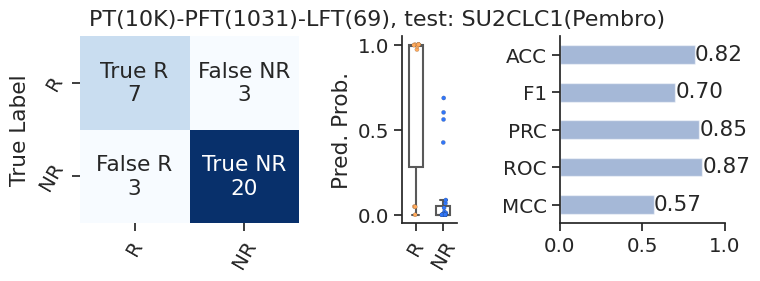

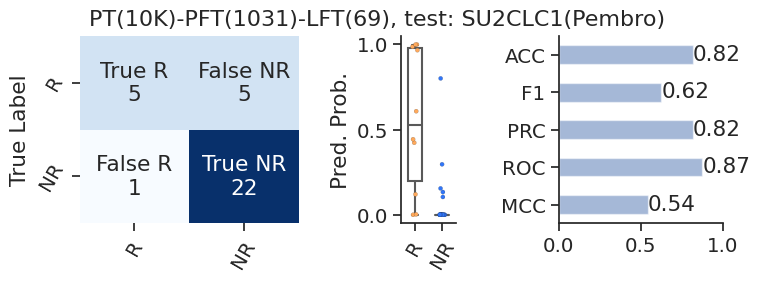

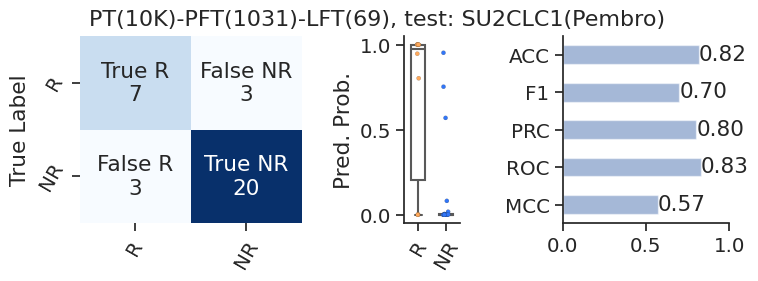

In [7]:
for mode1 in ['PFT']:
    for seed in seeds:
        for mode in ['LFT']: 
            print('Evaludation on Model %s' % mode)
            params['mode'] = mode
            params['seed'] = seed
            
            res = []
            work_dir = './PT(10K)-%s(%s)-%s(%s)-ep0/%s/' % (mode1, N1, mode, N, seed)
            if not os.path.exists(work_dir):
                os.makedirs(work_dir)
                
            finetuner_path = './PT(10K)-%s(%s)/%s/finetuner.pt' % (mode1, N1, seed)
            pretrainer = loadcompass(finetuner_path)
            finetuner = FineTuner(pretrainer, **params, 
                                  work_dir= work_dir, 
                                  task_name = '%s' % train_cohort_name)
            
            finetuner = finetuner.tune(dfcx_train = train_X,
                                       dfy_train = train_y, min_mcc=0.8)
    
            finetuner.save(os.path.join(work_dir, 'finetuner.pt'))
            
            _, pred_testy = finetuner.predict(test_cohort_X, batch_size = 16)
    
            pred_testy['train_cohort'] = train_cohort_name
            pred_testy['test_cohort'] = test_cohort_name 
            
            pred_testy['best_epoch'] = finetuner.best_epoch
            pred_testy['n_trainable_params'] = finetuner.count_parameters()
            pred_testy['mode'] = mode
            pred_testy['seed'] = seed
            pred_testy['batch_size'] = params['batch_size']
            pred_testy['task_dense_layer'] = str(params['task_dense_layer'])
            dfp = test_cohort_y.join(pred_testy)
    
            y_true, y_prob, y_pred = dfp['R'], dfp[1], dfp[[0, 1]].idxmax(axis=1)
            fig = plot_performance(y_true, y_prob, y_pred)
            fig.suptitle('PT(10K)-%s(%s)-%s(%s), test: %s' % (mode1, N1, mode, N, test_cohort_name), fontsize=16)
            fig.savefig(os.path.join(work_dir, 'train_%s_test_%s.pdf' % (train_cohort_name, test_cohort_name)))
            res.append(dfp)
    
            dfs = pd.concat(res)
            dfp = dfs.groupby(['train_cohort', 'test_cohort']).apply(lambda x:score2(x['R'], x[1], x[[0, 1]].idxmax(axis=1)))
        
            #roc, prc, f1, acc, mcc
            dfp = dfp.apply(pd.Series)
            dfp.columns = ['ROC', 'PRC', 'F1', 'ACC', 'MCC']
            dfp = dfp.reset_index()
            
            dfs.to_csv(os.path.join(work_dir, 'source_performance.tsv'), sep='\t')
            dfp.to_csv(os.path.join(work_dir, 'metric_performance.tsv'), sep='\t')
            